## 1. Google Colab Settings:

In [1]:
!pip install wandb

     |████████████████████████████████| 1.4MB 3.7MB/s 
     |████████████████████████████████| 460kB 15.4MB/s 
     |████████████████████████████████| 112kB 30.9MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=4ea7bc028ec0959d2a6545b682c532c905e5fc9197891b938566b7057131b861
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=802d9887cb783b45477d62c3bd4d7bcc87a227afa6b36449148c6cfe67342c23
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=73605 sha256=9f

In [2]:
!wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: dff003aa03e7d25df35a840b6f0660ae9675efb4
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [3]:
#GPU INFO
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 18 13:36:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
import sys
sys.path.append('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101')

## 2. Import packages and initalize model

In [6]:
# Pytorch libraries
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# Internal files
import config
import dataloader
import models
# from baseline import get_model, save_checkpoint

import math
import pandas
import os
import sys
import time
from collections import OrderedDict
import random

import wandb
import ipywidgets as widgets


In [7]:
def get_model():

    # Get model from config
    if config.model == "resnet18":
        model = models.resnet18(pretrained=config.pretrained)
    elif config.model == "resnet34":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnet50':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "resnet101":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "resnet152":
        model = models.resnet152(pretrained=config.pretrained)
    elif config.model == "resnext50_32x4d":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnext101_32x8d':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "wide_resnet50_2":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "wide_resnet101_2":
        model = models.resnet152(pretrained=config.pretrained)
    else:
        raise ValueError('%s not supported'.format(config.model))

    # Initialize fc layer
    (in_features, out_features) = model.fc.in_features, model.fc.out_features
    model.fc = torch.nn.Linear(in_features, out_features)
    return model


In [8]:
# Get the original_dataset
loader = dataloader.KeyDataLoader()
train_loader, valid_loader, test_loader = loader.run()

# Hyper Parameter settings
random.seed(config.seed)
# torch.cuda.set_device(config.gpuid)
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
use_cuda = torch.cuda.is_available()

# Networks setup
print('\nModel setup')
print('| Building network: {}'.format(config.model))
net = get_model()
tch_net = get_model()
pretrain_net = get_model()
test_net = get_model()

print('| load pretrained net. from checkpoint...')
checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.checkpoint + '.pth.tar')
pretrain_net.load_state_dict(checkpoint['state_dict'])

if use_cuda:
    net.cuda()
    tch_net.cuda()
    pretrain_net.cuda()
    test_net.cuda()
    cudnn.benchmark = True
pretrain_net.eval()

for param in tch_net.parameters():
    param.requires_grad = False
for param in pretrain_net.parameters():
    param.requires_grad = False


# Instantiate a loss function.
criterion = torch.nn.CrossEntropyLoss()
consistent_criterion = torch.nn.KLDivLoss()

#Initialize mentor
mentor_net = get_model()
if use_cuda:
    mentor_net.cuda()


Model setup
| Building network: resnet50


/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/models/resnet.py:116: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/models/resnet.py:118: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/models/resnet.py:119: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



| load pretrained net. from checkpoint...


In [9]:
def get_accy(loader):
    mentor_net.eval()
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = mentor_net(inputs)
            loss = criterion(outputs, targets)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    # Grab results results
    test_acc = 100. * correct/total
    test_results = "| loss: {:.3f}, acc: {:.3f}".format(
        loss.data.item(), test_acc)

    print(test_results)

## 3. Cross Entropy

### 3.1 Reload Cross Entropy Weights and evaluate results

In [ ]:
print('\nTesting model')
checkpoint = torch.load(config.drive_dir + '/checkpoint/cross_entropy.pth.tar')
mentor_net.load_state_dict(checkpoint['state_dict'])
print('\n Validation Accy:')
get_accy(valid_loader)
print('\n Test Accy:')
get_accy(test_loader)
print('\n Train Accy:')
get_accy(train_loader)


Testing model

 Validation Accy:
| loss: 0.455, acc: 75.314

 Test Accy:
| loss: 0.070, acc: 80.586

 Train Accy:
| loss: 0.220, acc: 95.891


### 3.2 Compute Cross Entropy predicted confidence for every trained sample

This section has a high computational time and generates the *Cross_Entropy.csv* file, if you already have this file skip this section.

In [ ]:
#Those parameters are key for discarding
pre_batch = config.batch_size
config.batch_size = 1
config.shuffle = False

# Get the dataloader with no shuffle
loader = dataloader.KeyDataLoader()
train_noshuffle_loader, _, _ = loader.run()

In [ ]:
  import pandas
  correct = 0
  total = 0

  target_list = []
  pred        = []
  confidence  = []

  for batch_idx, (inputs, targets) in enumerate(train_noshuffle_loader):
      if use_cuda:
          inputs, targets = inputs.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = mentor_net(inputs)
          loss = criterion(outputs, targets)  
          _, predicted = torch.max(outputs.data, 1)
          total += targets.size(0)
          correct += predicted.eq(targets.data).cpu().sum()
          
          # print(outputs.softmax(dim = 1))
          conf = float(torch.max(outputs.softmax(dim = 1)))
          # print(conf, end = '\r')
          targ = int(targets.data)
          pd = int(predicted)

          confidence.append(conf)
          target_list.append(targ)
          pred.append(pd)

  # Grab dataframe
  df = pandas.DataFrame()
  df["target_list"] = target_list
  df["pred"] = pred
  df["confidence"] = confidence
  print(100.*correct/total)

tensor(95.8915)


In [ ]:
train_df = pandas.read_csv(config.data_dir+config.train_dir, header=None)
train_df.columns = ["dir"]

#Merge directories with confidence
DF = df.merge(train_df,how = 'left', left_index = True, right_index = True)

In [ ]:
DF.to_csv(config.data_dir + "Cross_Entropy.csv")

### 3.3 Explore Cross Entropy prediction confidence

In [ ]:
DF = pandas.read_csv(config.data_dir + "Cross_Entropy.csv")

In [ ]:
DF

,Unnamed: 0,target_list,pred,confidence,dir
0,0,3,3,0.934926,/images/apple_pie/1350394.jpg
1,1,3,3,0.590683,/images/apple_pie/1354215.jpg
2,2,3,3,0.887396,/images/apple_pie/1355206.jpg
3,3,3,3,0.979474,/images/apple_pie/1357950.jpg
4,4,3,3,0.856681,/images/apple_pie/1361950.jpg
...,...,...,...,...,...
68170,68170,85,85,0.999998,/images/waffles/981485.jpg
68171,68171,85,85,0.994355,/images/waffles/98238.jpg
68172,68172,85,85,0.999610,/images/waffles/982668.jpg
68173,68173,85,85,0.997806,/images/waffles/995085.jpg


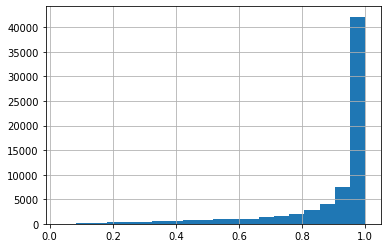

In [ ]:
DF.confidence.hist(bins = 20)

### 3.4 Data visualization

Top 3 more confident predictions for each class:

In [ ]:
top_confidence = pandas.DataFrame()
for p in set(DF.pred):
  df_tmp = DF[DF.pred == p][["confidence", "dir","pred"]].sort_values(["confidence"], ascending = False).head(3).copy()
  top_confidence = pandas.concat([top_confidence, df_tmp.T], axis = 1)

top_confidence = top_confidence.T
top_confidence

,confidence,dir,pred
35649,0.999799,/images/gyoza/494476.jpg,0
35609,0.999641,/images/gyoza/3871015.jpg,0
35756,0.999632,/images/gyoza/902140.jpg,0
65949,1,/images/takoyaki/368055.jpg,1
65882,0.999999,/images/takoyaki/3293086.jpg,1
...,...,...,...
2938,0.999772,/images/beef_tartare/2626160.jpg,99
3248,0.999721,/images/beef_tartare/3891016.jpg,99
10609,0.999966,/images/ceviche/3732824.jpg,100
10267,0.999949,/images/ceviche/1962222.jpg,100


Top 3 more confident images per class

In [ ]:
import ipywidgets as widgets
for p in set(top_confidence.pred):
  # print(top_confidence[top_confidence.pred == p])
  df_class = top_confidence[top_confidence.pred == p]
  img_lst = []
  for img in df_class.dir:
    print(img)
    img_lst.append(widgets.Image(value=open('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data' + img, 'rb').read(),width=100, height=100))
  hbox = widgets.HBox(img_lst)
  display(hbox)

/images/gyoza/494476.jpg


KeyboardInterrupt: ignored

Top 3 worse confident images per class

In [ ]:
 bottom_confidence = pandas.DataFrame()
for p in set(DF.target_list):
  df_tmp = DF[DF.target_list == p][["confidence", "dir","pred","target_list"]].sort_values(["confidence"], ascending = True).head(3).copy()
  bottom_confidence = pandas.concat([bottom_confidence, df_tmp.T], axis = 1)

bottom_confidence = bottom_confidence.T
bottom_confidence

,confidence,dir,pred,target_list
35659,0.150613,/images/gyoza/513659.jpg,95,0
35763,0.165264,/images/gyoza/931606.jpg,30,0
35123,0.249282,/images/gyoza/1551205.jpg,0,0
66008,0.0753808,/images/takoyaki/454978.jpg,1,1
65868,0.139015,/images/takoyaki/3214741.jpg,1,1
...,...,...,...,...
3205,0.0623548,/images/beef_tartare/3690157.jpg,38,99
3084,0.0965434,/images/beef_tartare/3224887.jpg,59,99
10731,0.162616,/images/ceviche/663120.jpg,100,100
10331,0.196232,/images/ceviche/2296727.jpg,100,100


In [ ]:
for p in set(bottom_confidence.target_list):
  # print(top_confidence[top_confidence.pred == p])
  df_class = bottom_confidence[bottom_confidence.target_list == p]
  img_lst = []
  for img in df_class.dir:
    print(img)
    img_lst.append(widgets.Image(value=open('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data' + img, 'rb').read(),width=100, height=100))
  hbox = widgets.HBox(img_lst)
  display(hbox)


/images/gyoza/513659.jpg
/images/gyoza/931606.jpg
/images/gyoza/1551205.jpg


/images/takoyaki/454978.jpg
/images/takoyaki/3214741.jpg
/images/takoyaki/2200696.jpg


/images/escargots/2244752.jpg


KeyboardInterrupt: ignored

##4. MLNT

### 4.1 Reload MLNT Weights and evaluate results

In [ ]:
print('\nTesting model')
checkpoint = torch.load(config.drive_dir + '/checkpoint/MLNT.pth.tar')
mentor_net.load_state_dict(checkpoint['state_dict'])
print('\n Validation Accy:')
get_accy(valid_loader)
print('\n Test Accy:')
get_accy(test_loader)
print('\n Train Accy:')
get_accy(train_loader)


Testing model

 Validation Accy:
| loss: 0.393, acc: 75.947

 Test Accy:
| loss: 0.012, acc: 80.958

 Train Accy:
| loss: 0.091, acc: 98.169


### 4.2 Compute MLNT predicted confidence for every trained sample

In [ ]:
#Those parameters are key for discarding
pre_batch = config.batch_size
config.batch_size = 1
config.shuffle = False

# Get the dataloader with no shuffle
loader = dataloader.KeyDataLoader()
train_noshuffle_loader, _, _ = loader.run()

In [ ]:
  import pandas
  correct = 0
  total = 0

  target_list = []
  pred        = []
  confidence  = []

  for batch_idx, (inputs, targets) in enumerate(train_noshuffle_loader):
      if use_cuda:
          inputs, targets = inputs.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = mentor_net(inputs)
          loss = criterion(outputs, targets)  
          _, predicted = torch.max(outputs.data, 1)
          total += targets.size(0)
          correct += predicted.eq(targets.data).cpu().sum()
          
          # print(outputs.softmax(dim = 1))
          conf = float(torch.max(outputs.softmax(dim = 1)))
          # print(conf, end = '\r')
          targ = int(targets.data)
          pd = int(predicted)

          confidence.append(conf)
          target_list.append(targ)
          pred.append(pd)

  # Grab dataframe
  df = pandas.DataFrame()
  df["target_list"] = target_list
  df["pred"] = pred
  df["confidence"] = confidence
  print(100.*correct/total)

tensor(98.1694)


In [ ]:
df

,target_list,pred,confidence
0,3,4,0.336063
1,3,3,0.699589
2,3,22,0.816754
3,3,3,0.774943
4,3,3,0.437220
...,...,...,...
25245,85,85,0.999765
25246,85,85,0.991557
25247,85,85,0.968589
25248,85,85,0.997610


In [ ]:
train_df = pandas.read_csv(config.data_dir+config.train_dir, header=None)
train_df.columns = ["dir"]

#Merge directories with confidence
DF = df.merge(train_df,how = 'left', left_index = True, right_index = True)


In [ ]:
DF.to_csv(config.data_dir + "MLNT.csv")

### 4.2 BIS Compute MLNT predicted confidence for every sample in test

In [ ]:
#Those parameters are key for discarding
pre_batch = config.batch_size
config.batch_size = 1
config.shuffle = False

# Get the dataloader with no shuffle
loader = dataloader.KeyDataLoader()
_, _, test_noshuffle_loader = loader.run()

In [ ]:
  import pandas
  correct = 0
  total = 0

  target_list = []
  pred        = []
  confidence  = []

  for batch_idx, (inputs, targets) in enumerate(test_noshuffle_loader):
      if use_cuda:
          inputs, targets = inputs.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = mentor_net(inputs)
          loss = criterion(outputs, targets)  
          _, predicted = torch.max(outputs.data, 1)
          total += targets.size(0)
          correct += predicted.eq(targets.data).cpu().sum()
          
          # print(outputs.softmax(dim = 1))
          conf = float(torch.max(outputs.softmax(dim = 1)))
          # print(conf, end = '\r')
          targ = int(targets.data)
          pd = int(predicted)

          confidence.append(conf)
          target_list.append(targ)
          pred.append(pd)

  # Grab dataframe
  df = pandas.DataFrame()
  df["target_list"] = target_list
  df["pred"] = pred
  df["confidence"] = confidence
  print(100.*correct/total)

tensor(80.9584)


In [ ]:
train_df = pandas.read_csv(config.data_dir+'clean_test_key_list.txt', header=None)
train_df.columns = ["dir"]

#Merge directories with confidence
DF = df.merge(train_df,how = 'left', left_index = True, right_index = True)

In [ ]:
DF.to_csv(config.data_dir + "MLNT_test_confidences.csv")

### 4.4 Explore MLNT test prediction confidence

In [18]:
DF = pandas.read_csv(config.data_dir + "MLNT_test_confidences.csv")

In [19]:
DF.shape

(25250, 5)

In [20]:
DF[DF.target_list == 49]

,Unnamed: 0,target_list,pred,confidence,dir
23750,23750,49,49,0.965047,sushi/101625
23751,23751,49,49,0.996949,sushi/1016390
23752,23752,49,49,0.999372,sushi/1032052
23753,23753,49,49,0.993375,sushi/1032351
23754,23754,49,49,0.996619,sushi/104332
...,...,...,...,...,...
23995,23995,49,49,0.963352,sushi/94385
23996,23996,49,49,0.975816,sushi/948335
23997,23997,49,49,0.998896,sushi/964994
23998,23998,49,49,0.870081,sushi/988559


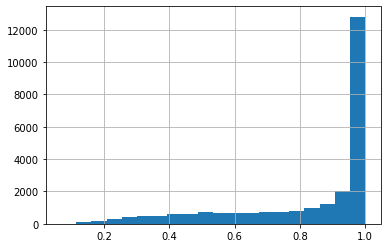

In [21]:
DF.confidence.hist(bins = 20)

In [22]:
bottom_confidence = pandas.DataFrame()
for p in set(DF.target_list):
  df_tmp = DF[DF.target_list == p][["confidence", "dir","pred","target_list"]].sort_values(["confidence"], ascending = True).head(20).copy()
  bottom_confidence = pandas.concat([bottom_confidence, df_tmp.T], axis = 1)

bottom_confidence = bottom_confidence.T
bottom_confidence

for p in [37,49,85,90,23, 33, 10]:
  # print(top_confidence[top_confidence.pred == p])
  df_class = bottom_confidence[bottom_confidence.target_list == p]
  img_lst = []
  
  for img in df_class.dir:
    # print(img)
    img_lst.append(widgets.Image(value=open('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data/images/' + img + '.jpg', 'rb').read(),width=100, height=100))
  print(img)

  hbox = widgets.HBox(img_lst)
  display(hbox)

hot_dog/42339


sushi/3445331


waffles/1544230


donuts/165928


pizza/447914


spaghetti_carbonara/2456012


spaghetti_bolognese/3289404


In [ ]:
bottom_confidence = pandas.DataFrame()
for p in set(DF.target_list):
  df_tmp = DF[DF.target_list == p][["confidence", "dir","pred","target_list"]].sort_values(["confidence"], ascending = False).head(20).copy()
  bottom_confidence = pandas.concat([bottom_confidence, df_tmp.T], axis = 1)

bottom_confidence = bottom_confidence.T
bottom_confidence

for p in [37,49,85,90,23, 33, 10]:
  # print(top_confidence[top_confidence.pred == p])
  df_class = bottom_confidence[bottom_confidence.target_list == p]
  img_lst = []
  
  for img in df_class.dir:
    # print(img)
    img_lst.append(widgets.Image(value=open('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data/images/' + img + '.jpg', 'rb').read(),width=100, height=100))
  print(img)

  hbox = widgets.HBox(img_lst)
  display(hbox)

hot_dog/3859916


sushi/3491909


waffles/883673


donuts/2164787


pizza/837119


spaghetti_carbonara/1764534


spaghetti_bolognese/421748


In [23]:
mappings = pandas.read_csv("/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data/mappings.csv")
mappings = mappings[["class_number", "class_name"]]
mappings.set_index("class_number", inplace = True)
mappings

,class_name
class_number,
0,gyoza
1,takoyaki
2,escargots
3,apple_pie
4,samosa
...,...
96,french_onion_soup
97,baby_back_ribs
98,churros


In [24]:
map_dict = mappings.to_dict()["class_name"]

In [25]:
DF["pred_descr"] = [map_dict[x] for x in DF.pred]

In [26]:
bottom_confidence = pandas.DataFrame()
for p in set(DF.target_list):
  df_tmp = DF[DF.target_list == p][["confidence", "dir","pred","target_list"]].sort_values(["confidence"], ascending = True).head(3).copy()
  bottom_confidence = pandas.concat([bottom_confidence, df_tmp.T], axis = 1)

bottom_confidence = bottom_confidence.T
bottom_confidence

for p in [37,49,85,90,23, 33, 10]:
  # print(top_confidence[top_confidence.pred == p])
  df_class = bottom_confidence[bottom_confidence.target_list == p]
  img_lst = []
  
  for img in df_class.dir:
    print(img)
    print(str(DF[DF.dir == img].pred_descr))
    img_lst.append(widgets.Image(value=open('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data/images/' + img + '.jpg', 'rb').read(),width=100, height=100))
    print("\n")

  hbox = widgets.HBox(img_lst)
  display(hbox)

hot_dog/3050381
13894    french_fries
Name: pred_descr, dtype: object


hot_dog/289472
13884    tacos
Name: pred_descr, dtype: object


hot_dog/2466383
13865    omelette
Name: pred_descr, dtype: object




sushi/838721
23981    bruschetta
Name: pred_descr, dtype: object


sushi/2291643
23835    sushi
Name: pred_descr, dtype: object


sushi/2056702
23825    sushi
Name: pred_descr, dtype: object




waffles/819721
25231    baby_back_ribs
Name: pred_descr, dtype: object


waffles/59277
25209    french_toast
Name: pred_descr, dtype: object


waffles/1972144
25083    cup_cakes
Name: pred_descr, dtype: object




donuts/1007399
7751    donuts
Name: pred_descr, dtype: object


donuts/2602953
7864    chocolate_mousse
Name: pred_descr, dtype: object


donuts/3099444
7905    dumplings
Name: pred_descr, dtype: object




pizza/1275885
19022    cheesecake
Name: pred_descr, dtype: object


pizza/1220156
19016    lasagna
Name: pred_descr, dtype: object


pizza/537575
19208    bruschetta
Name: pred_descr, dtype: object




spaghetti_carbonara/3356542
22912    huevos_rancheros
Name: pred_descr, dtype: object


spaghetti_carbonara/906675
22995    omelette
Name: pred_descr, dtype: object


spaghetti_carbonara/2746357
22875    huevos_rancheros
Name: pred_descr, dtype: object




spaghetti_bolognese/27149
22621    spaghetti_bolognese
Name: pred_descr, dtype: object


spaghetti_bolognese/2621372
22614    spaghetti_bolognese
Name: pred_descr, dtype: object


spaghetti_bolognese/3809374
22701    gnocchi
Name: pred_descr, dtype: object




### 4.3 Explore MLNT train prediction confidence

In [10]:
DF = pandas.read_csv(config.data_dir + "MLNT.csv")

In [11]:
DF.shape

(68175, 5)

In [15]:
DF[DF.confidence > 0.6].shape[0]/DF.shape[0]

0.9611294462779612

In [13]:
DF

,Unnamed: 0,target_list,pred,confidence,dir
0,0,3,3,0.987062,/images/apple_pie/1350394.jpg
1,1,3,3,0.810526,/images/apple_pie/1354215.jpg
2,2,3,3,0.906228,/images/apple_pie/1355206.jpg
3,3,3,3,0.985447,/images/apple_pie/1357950.jpg
4,4,3,3,0.856490,/images/apple_pie/1361950.jpg
...,...,...,...,...,...
68170,68170,85,85,0.999973,/images/waffles/981485.jpg
68171,68171,85,85,0.992433,/images/waffles/98238.jpg
68172,68172,85,85,0.997625,/images/waffles/982668.jpg
68173,68173,85,85,0.999936,/images/waffles/995085.jpg


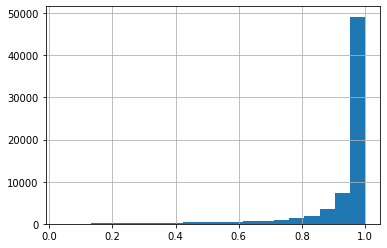

In [14]:
DF.confidence.hist(bins = 20)

### 4.4 MLNT Data Visualization

In [ ]:
top_confidence = pandas.DataFrame()
for p in set(DF.pred):
  df_tmp = DF[DF.pred == p][["confidence", "dir","pred"]].sort_values(["confidence"], ascending = False).head(1).copy()
  top_confidence = pandas.concat([top_confidence, df_tmp.T], axis = 1)

top_confidence = top_confidence.T
top_confidence

,confidence,dir,pred
35191,0.999974,/images/gyoza/1903351.jpg,0
65831,1,/images/takoyaki/3027423.jpg,1
23769,1,/images/escargots/1989292.jpg,2
371,0.999937,/images/apple_pie/2994917.jpg,3
57898,0.999999,/images/samosa/3866411.jpg,4
...,...,...,...
28313,0.999976,/images/french_onion_soup/823002.jpg,96
996,0.999947,/images/baby_back_ribs/2785758.jpg,97
16061,0.99999,/images/churros/3856799.jpg,98
3092,0.999785,/images/beef_tartare/3248562.jpg,99


In [ ]:
for x in top_confidence.dir:
  print(x)

/images/gyoza/1903351.jpg
/images/takoyaki/3027423.jpg
/images/escargots/1989292.jpg
/images/apple_pie/2994917.jpg
/images/samosa/3866411.jpg
/images/huevos_rancheros/1568417.jpg
/images/caesar_salad/3233214.jpg
/images/risotto/2228391.jpg
/images/panna_cotta/3613395.jpg
/images/strawberry_shortcake/206174.jpg
/images/spaghetti_bolognese/2123343.jpg
/images/fried_rice/49075.jpg
/images/grilled_cheese_sandwich/751419.jpg
/images/breakfast_burrito/1729039.jpg
/images/chicken_quesadilla/3685128.jpg
/images/gnocchi/2944708.jpg
/images/shrimp_and_grits/1738674.jpg
/images/beet_salad/3430085.jpg
/images/frozen_yogurt/773597.jpg
/images/scallops/1676148.jpg
/images/edamame/740043.jpg
/images/french_fries/309651.jpg
/images/baklava/2390366.jpg
/images/pizza/759025.jpg
/images/macaroni_and_cheese/3282057.jpg
/images/guacamole/989033.jpg
/images/hot_and_sour_soup/3358351.jpg
/images/dumplings/3206457.jpg
/images/nachos/1622536.jpg
/images/lasagna/2094988.jpg
/images/grilled_salmon/3201992.jpg
/i

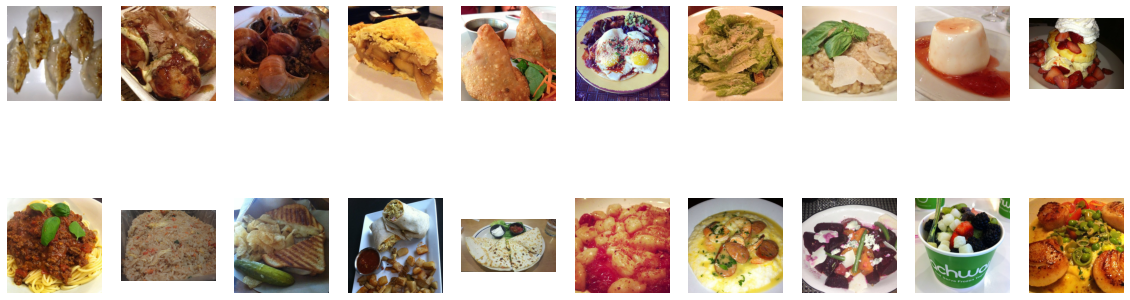

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in top_confidence.dir[:20]:
    images.append(mpimg.imread('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data' + img_path))

plt.figure(figsize=(20,10))
columns = 10
plt.tight_layout()
for i, image in enumerate(images):
    
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(image)

TypeError: ignored

<Figure size 288x288 with 0 Axes>

In [ ]:
import ipywidgets as widgets
for p in set(top_confidence.pred):
  # print(top_confidence[top_confidence.pred == p])
  df_class = top_confidence[top_confidence.pred == p]
  img_lst = []
  for img in df_class.dir:
    print(img)
    # img_lst.append(widgets.Image(value=open('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data' + img, 'rb').read(),width=100, height=100))
  hbox = widgets.HBox(img_lst)
  display(hbox)

/images/gyoza/1903351.jpg


HBox()

/images/takoyaki/3027423.jpg


HBox()

/images/escargots/1989292.jpg


HBox()

/images/apple_pie/2994917.jpg


HBox()

/images/samosa/3866411.jpg


HBox()

/images/huevos_rancheros/1568417.jpg


HBox()

/images/caesar_salad/3233214.jpg


HBox()

/images/risotto/2228391.jpg


HBox()

/images/panna_cotta/3613395.jpg


HBox()

/images/strawberry_shortcake/206174.jpg


HBox()

/images/spaghetti_bolognese/2123343.jpg


HBox()

/images/fried_rice/49075.jpg


HBox()

/images/grilled_cheese_sandwich/751419.jpg


HBox()

/images/breakfast_burrito/1729039.jpg


HBox()

/images/chicken_quesadilla/3685128.jpg


HBox()

/images/gnocchi/2944708.jpg


HBox()

/images/shrimp_and_grits/1738674.jpg


HBox()

/images/beet_salad/3430085.jpg


HBox()

/images/frozen_yogurt/773597.jpg


HBox()

/images/scallops/1676148.jpg


HBox()

/images/edamame/740043.jpg


HBox()

/images/french_fries/309651.jpg


HBox()

/images/baklava/2390366.jpg


HBox()

/images/pizza/759025.jpg


HBox()

/images/macaroni_and_cheese/3282057.jpg


HBox()

/images/guacamole/989033.jpg


HBox()

/images/hot_and_sour_soup/3358351.jpg


HBox()

/images/dumplings/3206457.jpg


HBox()

/images/nachos/1622536.jpg


HBox()

/images/lasagna/2094988.jpg


HBox()

/images/grilled_salmon/3201992.jpg


HBox()

/images/ice_cream/1538888.jpg


HBox()

/images/beignets/3900337.jpg


HBox()

/images/spaghetti_carbonara/2396931.jpg


HBox()

/images/miso_soup/2179589.jpg


HBox()

/images/bibimbap/2846972.jpg


HBox()

/images/pork_chop/894805.jpg


HBox()

/images/hot_dog/3399374.jpg


HBox()

/images/clam_chowder/3073323.jpg


HBox()

/images/eggs_benedict/1892674.jpg


HBox()

/images/paella/2018761.jpg


HBox()

/images/hamburger/2184165.jpg


HBox()

/images/lobster_roll_sandwich/1962310.jpg


HBox()

/images/pho/1563592.jpg


HBox()

/images/prime_rib/1459859.jpg


HBox()

/images/omelette/1640730.jpg


HBox()

/images/chicken_wings/287656.jpg


HBox()

/images/spring_rolls/2796134.jpg


HBox()

/images/tuna_tartare/3050907.jpg


HBox()

/images/sushi/133637.jpg


HBox()

/images/fried_calamari/3418841.jpg


HBox()

/images/chocolate_mousse/2019512.jpg


HBox()

/images/croque_madame/3572509.jpg


HBox()

/images/foie_gras/1599908.jpg


HBox()

/images/chocolate_cake/3331639.jpg


HBox()

/images/cup_cakes/1493009.jpg


HBox()

/images/macarons/3409723.jpg


HBox()

/images/mussels/2816103.jpg


HBox()

/images/oysters/3293938.jpg


HBox()

/images/garlic_bread/3539413.jpg


HBox()

/images/cheesecake/3032644.jpg


HBox()

/images/tacos/2404214.jpg


HBox()

/images/filet_mignon/3843271.jpg


HBox()

/images/carrot_cake/2697980.jpg


HBox()

/images/ramen/895075.jpg


HBox()

/images/hummus/1701533.jpg


HBox()

/images/lobster_bisque/1763227.jpg


HBox()

/images/onion_rings/77500.jpg


HBox()

/images/seaweed_salad/3818492.jpg


HBox()

/images/cheese_plate/3520078.jpg


HBox()

/images/pulled_pork_sandwich/3815114.jpg


HBox()

/images/cannoli/1882406.jpg


HBox()

/images/falafel/1461412.jpg


HBox()

/images/beef_carpaccio/3049536.jpg


HBox()

/images/steak/669960.jpg


HBox()

/images/club_sandwich/2502531.jpg


HBox()

/images/greek_salad/3646757.jpg


HBox()

/images/french_toast/1518268.jpg


HBox()

/images/caprese_salad/1818008.jpg


HBox()

/images/poutine/3310788.jpg


HBox()

/images/pad_thai/194285.jpg


HBox()

/images/peking_duck/69195.jpg


HBox()

/images/bread_pudding/3624157.jpg


HBox()

/images/pancakes/3665440.jpg


HBox()

/images/chicken_curry/2202573.jpg


HBox()

/images/waffles/2138642.jpg


HBox()

/images/creme_brulee/421252.jpg


HBox()

/images/sashimi/2830725.jpg


HBox()

/images/deviled_eggs/2891213.jpg


HBox()

/images/red_velvet_cake/740176.jpg


HBox()

/images/donuts/794976.jpg


HBox()

/images/crab_cakes/1945557.jpg


HBox()

/images/bruschetta/3836578.jpg


HBox()

/images/fish_and_chips/3783246.jpg


HBox()

/images/tiramisu/442915.jpg


HBox()

/images/ravioli/3882934.jpg


HBox()

/images/french_onion_soup/823002.jpg


HBox()

/images/baby_back_ribs/2785758.jpg


HBox()

/images/churros/3856799.jpg


HBox()

/images/beef_tartare/3248562.jpg


HBox()

/images/ceviche/1561836.jpg


HBox()

In [ ]:

bottom_confidence = pandas.DataFrame()
for p in set(DF.target_list):
  df_tmp = DF[DF.target_list == p][["confidence", "dir","pred","target_list"]].sort_values(["confidence"], ascending = True).head(1).copy()
  bottom_confidence = pandas.concat([bottom_confidence, df_tmp.T], axis = 1)

bottom_confidence = bottom_confidence.T
bottom_confidence

,confidence,dir,pred,target_list
35763,0.183881,/images/gyoza/931606.jpg,4,0
65892,0.148507,/images/takoyaki/3375978.jpg,37,1
23670,0.136326,/images/escargots/1550514.jpg,2,2
176,0.154987,/images/apple_pie/2298862.jpg,59,3
58026,0.08407,/images/samosa/905570.jpg,15,4
...,...,...,...,...
28255,0.185194,/images/french_onion_soup/530995.jpg,26,96
970,0.111684,/images/baby_back_ribs/2622530.jpg,97,97
15879,0.0756248,/images/churros/2946237.jpg,98,98
3205,0.0674908,/images/beef_tartare/3690157.jpg,69,99


In [ ]:
for p in set(bottom_confidence.target_list):
  # print(top_confidence[top_confidence.pred == p])
  df_class = bottom_confidence[bottom_confidence.target_list == p]
  img_lst = []
  for img in df_class.dir:
    print(img)
    img_lst.append(widgets.Image(value=open('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data' + img, 'rb').read(),width=100, height=100))
  hbox = widgets.HBox(img_lst)
  display(hbox)


/images/gyoza/931606.jpg
/images/gyoza/3427995.jpg
/images/gyoza/2477631.jpg


/images/takoyaki/3375978.jpg
/images/takoyaki/2166365.jpg
/images/takoyaki/1931095.jpg


/images/escargots/1550514.jpg


KeyboardInterrupt: ignored

In [16]:
bottom_confidence = pandas.DataFrame()
for p in set(DF.target_list):
  df_tmp = DF[DF.target_list == p][["confidence", "dir","pred","target_list"]].sort_values(["confidence"], ascending = True).head(3).copy()
  bottom_confidence = pandas.concat([bottom_confidence, df_tmp.T], axis = 1)

bottom_confidence = bottom_confidence.T
bottom_confidence

for p in [37,49,85,90,23, 33, 10]:
  # print(top_confidence[top_confidence.pred == p])
  df_class = bottom_confidence[bottom_confidence.target_list == p]
  img_lst = []
  
  for img in df_class.dir:
    print(img)
    img_lst.append(widgets.Image(value=open('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data' + img, 'rb').read(),width=100, height=100))
  print(img)

  hbox = widgets.HBox(img_lst)
  display(hbox)

/images/hot_dog/3222202.jpg
/images/hot_dog/2817210.jpg
/images/hot_dog/1714229.jpg
/images/hot_dog/1714229.jpg


/images/sushi/1446129.jpg
/images/sushi/769781.jpg
/images/sushi/3499178.jpg
/images/sushi/3499178.jpg


/images/waffles/3785474.jpg
/images/waffles/1596095.jpg
/images/waffles/771512.jpg
/images/waffles/771512.jpg


/images/donuts/3347684.jpg
/images/donuts/1670061.jpg
/images/donuts/921183.jpg
/images/donuts/921183.jpg


/images/pizza/1454995.jpg
/images/pizza/32666.jpg
/images/pizza/625687.jpg
/images/pizza/625687.jpg


/images/spaghetti_carbonara/1787341.jpg
/images/spaghetti_carbonara/546865.jpg
/images/spaghetti_carbonara/3048683.jpg
/images/spaghetti_carbonara/3048683.jpg


/images/spaghetti_bolognese/2117379.jpg
/images/spaghetti_bolognese/491434.jpg
/images/spaghetti_bolognese/2372258.jpg
/images/spaghetti_bolognese/2372258.jpg


In [17]:


bottom_confidence = pandas.DataFrame()
for p in set(DF.target_list):
  df_tmp = DF[DF.target_list == p][["confidence", "dir","pred","target_list"]].sort_values(["confidence"], ascending = False).head(3).copy()
  bottom_confidence = pandas.concat([bottom_confidence, df_tmp.T], axis = 1)

bottom_confidence = bottom_confidence.T
bottom_confidence

for p in [37,49,85,90,23, 33, 10]:
  # print(top_confidence[top_confidence.pred == p])
  df_class = bottom_confidence[bottom_confidence.target_list == p]
  img_lst = []
  
  for img in df_class.dir:
    print(img)
    img_lst.append(widgets.Image(value=open('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data' + img, 'rb').read(),width=100, height=100))
  print(img)

  hbox = widgets.HBox(img_lst)
  display(hbox)

/images/hot_dog/3399374.jpg
/images/hot_dog/3129883.jpg
/images/hot_dog/1621091.jpg
/images/hot_dog/1621091.jpg


/images/sushi/133637.jpg
/images/sushi/390178.jpg
/images/sushi/309738.jpg
/images/sushi/309738.jpg


/images/waffles/2138642.jpg
/images/waffles/361476.jpg
/images/waffles/2580463.jpg
/images/waffles/2580463.jpg


/images/donuts/794976.jpg
/images/donuts/2226530.jpg
/images/donuts/2194788.jpg
/images/donuts/2194788.jpg


/images/pizza/759025.jpg
/images/pizza/3830773.jpg
/images/pizza/3478964.jpg
/images/pizza/3478964.jpg


/images/spaghetti_carbonara/2396931.jpg
/images/spaghetti_carbonara/2959930.jpg
/images/spaghetti_carbonara/2272197.jpg
/images/spaghetti_carbonara/2272197.jpg


/images/spaghetti_bolognese/2123343.jpg
/images/spaghetti_bolognese/743497.jpg
/images/spaghetti_bolognese/2631531.jpg
/images/spaghetti_bolognese/2631531.jpg


## Confusion Matrix

### 

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(DF.target_list, DF.pred, normalize = 'true')
cm

array([[0.856, 0.   , 0.   , ..., 0.004, 0.   , 0.   ],
       [0.   , 0.892, 0.004, ..., 0.004, 0.   , 0.   ],
       [0.   , 0.004, 0.88 , ..., 0.   , 0.   , 0.004],
       ...,
       [0.   , 0.   , 0.   , ..., 0.896, 0.   , 0.   ],
       [0.   , 0.   , 0.004, ..., 0.   , 0.804, 0.012],
       [0.   , 0.   , 0.   , ..., 0.   , 0.004, 0.696]])

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(23, 23))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    # thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     if normalize:
    #         plt.text(j, i, "{:0.4f}".format(cm[i, j]),
    #                  horizontalalignment="center",
    #                  color="white" if cm[i, j] > thresh else "black")
    #     else:
    #         plt.text(j, i, "{:,}".format(cm[i, j]),
    #                  horizontalalignment="center",
    #                  color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

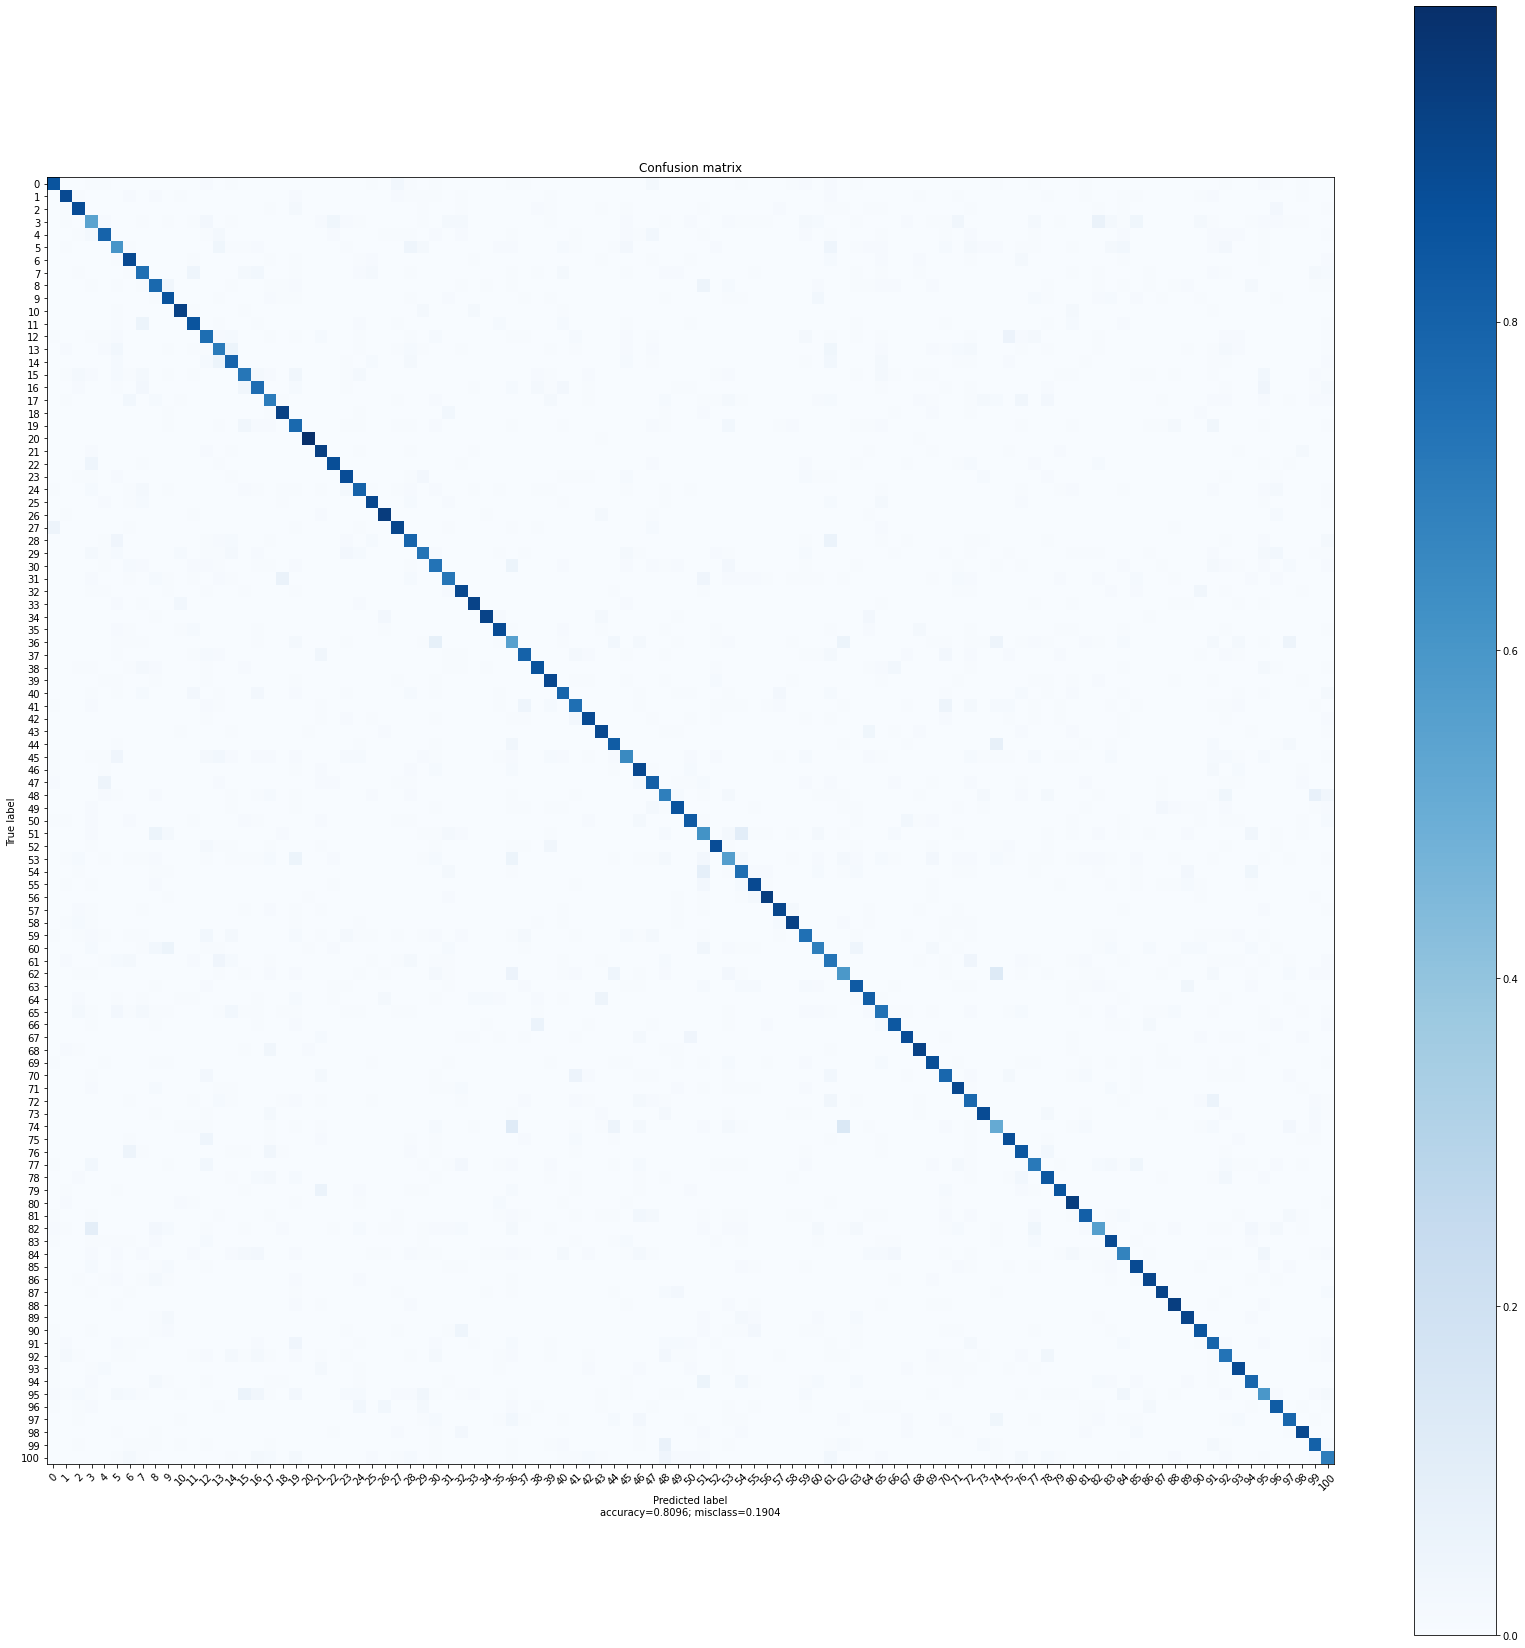

In [ ]:
plot_confusion_matrix(cm,list(set(DF.pred)))